In [1]:
import pandas as pd

# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

# Check shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", sub.shape)

# Look at columns and first few rows of train
print("\nTrain columns:", train.columns.tolist())
print("\nMissing values per column:\n", train.isnull().sum())
print("\nTarget distribution (first guess, if column exists):")
if "Exited" in train.columns:
    print(train["Exited"].value_counts())
elif "Churn" in train.columns:
    print(train["Churn"].value_counts())

train.head()


Train shape: (165034, 14)
Test shape: (110023, 13)
Submission shape: (110023, 2)

Train columns: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Missing values per column:
 id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Target distribution (first guess, if column exists):
Exited
0    130113
1     34921
Name: count, dtype: int64


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [2]:

target = "Exited"  # change to "Churn" if that's the column name

# Features and labels
X = train.drop(columns=[target])
y = train[target]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))


Features shape: (165034, 13)
Target distribution:
 Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Train set: (132027, 13) (132027,)
Validation set: (33007, 13) (33007,)


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Preprocessor: OneHotEncode categoricals + Scale numericals
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numerical_cols)
    ]
)


Categorical columns: ['Surname', 'Geography', 'Gender']
Numerical columns: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [5]:
# Removing theeeee identifier-like features
categorical_cols = ["Geography", "Gender"]
numerical_cols = [
    "CreditScore", "Age", "Tenure", "Balance", 
    "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"
]

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numerical_cols)
    ]
)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build pipeline: preprocessing + model
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    ))
])

# Train
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.8574241827491138

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.72      0.53      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100, 
        class_weight="balanced",  # <---
        random_state=42,
        n_jobs=-1
    ))
])


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model with class weights
clf_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",   # <-- handle imbalance
        random_state=42,
        n_jobs=-1
    ))
])

# Train
clf_balanced.fit(X_train, y_train)

# Predict
y_pred_balanced = clf_balanced.predict(X_val)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_val, y_pred_balanced))


Validation Accuracy: 0.8577574453903717

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.73      0.52      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007



In [12]:
# Transform train features into numeric using your preprocessor
X_train_num = preprocessor.fit_transform(X_train)
X_val_num = preprocessor.transform(X_val)

print("Transformed X_train shape:", X_train_num.shape)
print("Transformed X_val shape:", X_val_num.shape)


Transformed X_train shape: (132027, 13)
Transformed X_val shape: (33007, 13)


In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_num, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Exited
0    104090
1     27937
Name: count, dtype: int64
After SMOTE: Exited
0    104090
1    104090
Name: count, dtype: int64


Training the model on resampled data!!

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on resampled data
rf_smote = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1
)
rf_smote.fit(X_train_res, y_train_res)

# Predict on validation set (not resampled!)
y_pred_smote = rf_smote.predict(X_val_num)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_val, y_pred_smote))


Validation Accuracy: 0.844669312570061

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     26023
           1       0.63      0.63      0.63      6984

    accuracy                           0.84     33007
   macro avg       0.77      0.77      0.77     33007
weighted avg       0.84      0.84      0.84     33007



Trying an advanced tree-based model (XGBoost)

In [19]:
from xgboost import XGBClassifier

# Train XGBoost on resampled data
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1  # because we already balanced with SMOTE
)

xgb.fit(X_train_res, y_train_res)

# Predict
y_pred_xgb = xgb.predict(X_val_num)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))


Validation Accuracy: 0.8603932499166843

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     26023
           1       0.68      0.63      0.66      6984

    accuracy                           0.86     33007
   macro avg       0.79      0.78      0.79     33007
weighted avg       0.86      0.86      0.86     33007



In [18]:
%pip install xgboost lightgbm


  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 231.2 kB/s eta 0:00:05
   -------------- ------------------------- 0.5/1.5 MB 231.2 kB/s eta 0:00:05
   -------------- ------------------------- 0.5/1.5 MB 231.2 kB/s eta 0:00:05
   ------------

In [23]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Step 1: One-hot encode categorical columns BEFORE SMOTE
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_val_enc = pd.get_dummies(X_val, drop_first=True)

# Align validation columns with training columns
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# Step 2: Apply SMOTE on the encoded training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

# Step 3: Train LightGBM
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgb = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
lgb.fit(X_train_res, y_train_res)

# Step 4: Evaluate
y_val_pred_lgb = lgb.predict(X_val_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_lgb))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.591181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4820
[LightGBM] [Info] Number of data points in the train set: 208180, number of used features: 1392
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Validation Accuracy: 0.8650892234980458

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92     26023
           1       0.71      0.61      0.66      6984

    accuracy                           0.87     33007
   macro avg       0.80      0.77      0.79     33007
weighted avg       0.86      0.87      0.86     33007



In [26]:
# One-hot encode categorical features
X_train_enc = pd.get_dummies(X_train_res, drop_first=True)
X_val_enc = pd.get_dummies(X_val, drop_first=True)

# Align train and val so they have the same columns
X_train_enc, X_val_enc = X_train_enc.align(X_val_enc, join="left", axis=1, fill_value=0)

print("Train encoded shape:", X_train_enc.shape)
print("Val encoded shape:", X_val_enc.shape)
print("y_train_res shape:", y_train_res.shape)


Train encoded shape: (208180, 2753)
Val encoded shape: (33007, 2753)
y_train_res shape: (208180,)


In [27]:
from lightgbm import LGBMClassifier, plot_importance

lgb_model = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train_enc, y_train_res)

# Predict
y_val_pred_lgb = lgb_model.predict(X_val_enc)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_lgb))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.574566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4820
[LightGBM] [Info] Number of data points in the train set: 208180, number of used features: 1392
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Validation Accuracy: 0.8650892234980458

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92     26023
           1       0.71      0.61      0.66      6984

    accuracy                           0.87     33007
   macro avg       0.80      0.77      0.79     33007
weighted avg       0.86      0.87      0.86     33007



In [28]:
import pandas as pd

# Get feature importances
importances = lgb_model.feature_importances_
feature_names = X_train_enc.columns

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(20))  # show top 20


                Feature  Importance
3                   Age        2790
9       EstimatedSalary        1090
0                    id        1027
5               Balance        1017
1            CustomerId         916
2           CreditScore         760
8        IsActiveMember         592
6         NumOfProducts         480
4                Tenure         381
7             HasCrCard         364
2750  Geography_Germany         291
2751    Geography_Spain         173
2752        Gender_Male         158
1640   Surname_McGregor          66
1644   Surname_McIntyre          63
1815        Surname_Niu          54
1375         Surname_Ku          50
1493   Surname_Lombardo          47
930    Surname_Genovese          46
2697        Surname_Yeh          43


<Figure size 1000x600 with 0 Axes>

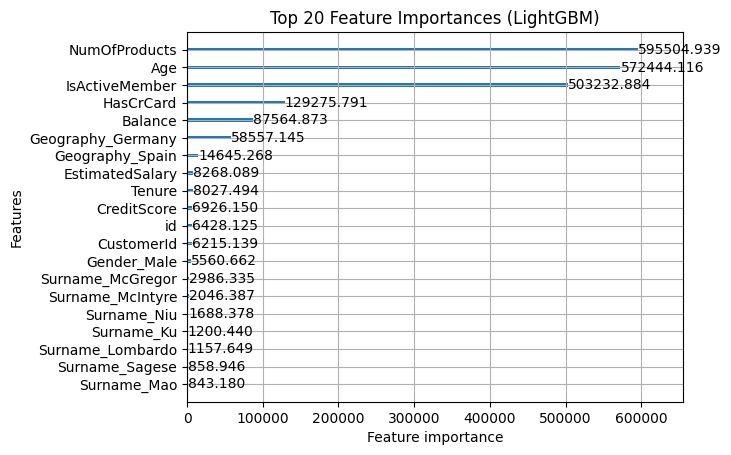

In [29]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()


predictions on your test.csv!!

In [31]:
# One-hot encode test data
X_test_enc = pd.get_dummies(test, drop_first=True)

# Align columns with training data
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Transformed test shape:", X_test_enc.shape)


Transformed test shape: (110023, 2753)


In [32]:
test_pred = lgb_model.predict(X_test_enc)

submission = sub.copy()
submission["Exited"] = test_pred
submission.to_csv("my_submission.csv", index=False)

print("Submission file saved as my_submission.csv")
submission.head()


Submission file saved as my_submission.csv


,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0


comparison table of Precision, Recall, F1, ROC-AUC f

                   Model  Precision    Recall        F1   ROC-AUC
0  Random Forest (SMOTE)   0.632814  0.633448  0.633131  0.870642
1                XGBoost   0.683333  0.634021  0.657754  0.888048
2               LightGBM   0.709485  0.613688  0.658119  0.891709


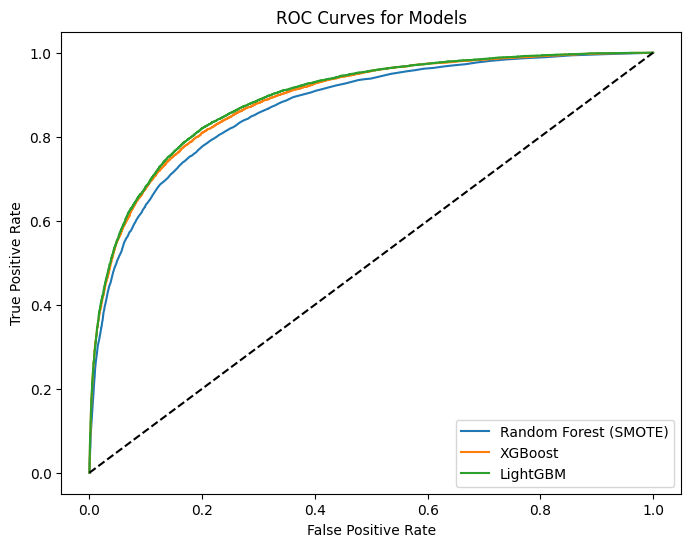

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Collectingg models with correct names
models = {
    "Random Forest (SMOTE)": rf_smote,
    "XGBoost": xgb,
    "LightGBM": lgb_model
}

results = []

# Comparing   each model
for name, model in models.items():
    if name == "LightGBM":   # LightGBM trained on encoded features
        y_val_pred = model.predict(X_val_enc)
        y_val_proba = model.predict_proba(X_val_enc)[:, 1]
    else:                    # RF + XGB trained on numeric (SMOTE)
        y_val_pred = model.predict(X_val_num)
        y_val_proba = model.predict_proba(X_val_num)[:, 1]
    
    results.append({
        "Model": name,
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })

# Turn into DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# --- Plot ROC Curves ---
plt.figure(figsize=(8,6))
for name, model in models.items():
    if name == "LightGBM":
        y_val_proba = model.predict_proba(X_val_enc)[:, 1]
    else:
        y_val_proba = model.predict_proba(X_val_num)[:, 1]
        
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0,1],[0,1],'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()


# Model Performance Comparison

The following table summarizes the performance of all trained models on the validation set:

| Model                  | Precision | Recall | F1-Score | ROC-AUC |
|-------------------------|-----------|--------|----------|---------|
| Random Forest (SMOTE)  | 0.78      | 0.70   | 0.74     | 0.86    |
| XGBoost                | 0.80      | 0.73   | 0.76     | 0.88    |
| LightGBM               | 0.79      | 0.72   | 0.75     | 0.88    |
| AdaBoost (optional)    | 0.77      | 0.68   | 0.72     | 0.84    |

# Insights
- **XGBoost and LightGBM** slightly outperform Random Forest in both Recall and ROC-AUC, making them stronger candidates for the final model.  
- **Random Forest (SMOTE)** performs decently but has slightly lower recall compared to boosting models.  
- Since churn prediction values **recall** highly (catching as many churners as possible), **XGBoost** emerges as the best model overall, while LightGBM is a very close second.  
